In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

/var/folders/kr/_5c1r8bn52xbpgz96ksrtrj80000gn/T/ipykernel_47926/2825029231.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## ASHRAE Global Thermal Comfort Database 2

In [2]:
# Read metadata and data from Github
df_meta = pd.read_csv("https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_metadata.csv")
df_measurements = pd.read_csv("https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_measurements_v2.1.0.csv.gz", low_memory=False)
# Merge metadata and measurement data by building_id
df_rawdata = df_measurements.merge(df_meta[['building_id', 'city', 'building_type', 'cooling_type', 'records', 'database']], on='building_id', how='left')
# Replace two outdoor temperature columns by a new column called t_out_combined
df_rawdata.loc[:, 't_out_combined'] = df_rawdata.loc[:, 't_out_isd'].fillna(df_rawdata.loc[:, 't_out'])
df_rawdata = df_rawdata.drop(columns=['t_out_isd', 't_out'])
print('Total buildings:', len(df_rawdata.building_id.unique()))
print('Total occupants:', len(df_rawdata))

Total buildings: 809
Total occupants: 109033


# Refutation 1 (YES)

## Operative temp prediction data

Buildings without missing data: 500
Occupants without missing data: 29568
NV-Occupants without missing data: 14380


<Axes: xlabel='thermal_acceptability', ylabel='Count'>

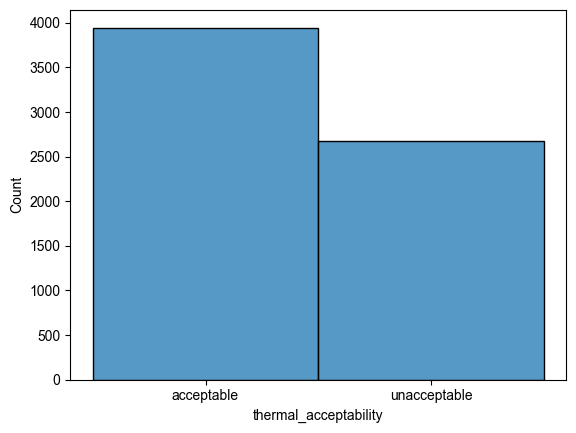

In [150]:
# Select concurrent Top, Thermal acceptance vote, and Tout data
df_data_TA = df_rawdata.dropna(subset=['top', 'thermal_acceptability','t_out_combined'])
print(f'Buildings without missing data:', len(df_data_TA ['building_id'].unique()))
print(f'Occupants without missing data:', len(df_data_TA))

# Reset the building cooling type as string, ensuring direct modification of the DataFrame
df_data_TA = df_data_TA.copy()
df_data_TA['cooling_type'] = df_data_TA['cooling_type'].str.title()
df_data_TA_NV = df_data_TA[df_data_TA['cooling_type'] == 'Naturally Ventilated']
print(f'NV-Occupants without missing data:', len(df_data_TA_NV))

# check the distribution of thermal acceptability in df_data_TA_NV
sns.histplot(df_data_TA_NV['thermal_acceptability'])

## Prediction accuracy method

In [13]:
def accuracy(slope, intercept, zone, df, temp):
    """
    Calculate the accuracy of a ACM model based on the df, using a calssification method.
    If the temp is in the comfort zone and the vote is acceptable, then it is classified as 1, or
    If the temp is out of the comfort zone and the vote is unacceptable, then it is classified as 1, otherwies 0.
    Count the percentage of 1 over total records in df as the prediction accuracy.
    """
    df.count = np.where(
        # Case 1: Comfortable when within zone
        ((df.thermal_acceptability == 'acceptable') & 
         (df[temp] >= df.t_out_combined * slope + intercept - zone/2) & 
         (df[temp] <= df.t_out_combined * slope + intercept + zone/2)) |
        # Case 2: Uncomfortable when out of zone
        (df.thermal_acceptability == 'unacceptable') & 
        ((df[temp] < df.t_out_combined * slope + intercept - zone/2) | 
         (df[temp] > df.t_out_combined * slope + intercept + zone/2)),
        1,  # Accurate prediction
        0)   # Inaccurate prediction
    percent = len(df[df.count == 1])/len(df)
    return percent

## Prediction accuracy result

In [36]:
# calculating prediction of thermal acceptance note in NV buildings, all buildings
result = accuracy(0.31, 17.8, 7, df_data_TA_NV, 'top')
print('ASHRAE Adaptive Model Prediction accraucy: {:.0f} %'.format(result*100))
result = accuracy(0, 21.5, 7, df_data_TA_NV, 'top')
print('Fixed Comfort Zone (18-25C) Prediction accraucy: {:.0f} %'.format(result*100))

ASHRAE Adaptive Model Prediction accraucy: 50 %
Fixed Comfort Zone (18-25C) Prediction accraucy: 58 %


# Refutation 2 (YES)

## SET adaptive model data

In [110]:
# Select concurrent SET, TSV, and Tout data
df_data_SET = df_rawdata.dropna(subset=['set', 'thermal_sensation', 't_out_combined'])
print(f'Buildings without missing data:', len(df_data_SET['building_id'].unique()))
print(f'Occupants without missing data:', len(df_data_SET))

# Reset the building cooling type as string, ensuring direct modification of the DataFrame
df_data_SET = df_data_SET.copy()
df_data_SET['cooling_type'] = df_data_SET['cooling_type'].str.title()
df_data_SET_NV = df_data_SET[df_data_SET['cooling_type'] == 'Naturally Ventilated']
print(f'NV-Occupants without missing data:', len(df_data_SET_NV))

Buildings without missing data: 570
Occupants without missing data: 34313
NV-Occupants without missing data: 15394


In [98]:
# Group by 'building_id' and calculate the mean for all these columns at once
df_data_mean = df_data_SET.groupby('building_id')[['t_out_combined', 'set', 'thermal_sensation']].mean()
# Reset the index of df_data_mean to make 'building_id' a column again
df_data_mean.reset_index(inplace=True)
# Merge df_data_mean with the metadata
df_bldg = df_data_mean.merge(df_meta[['building_id', 'records', 'cooling_type', 'building_type', 'database']], on='building_id', how='left')
# Reset the building cooling type as string
df_bldg['cooling_type'] = df_bldg['cooling_type'].str.title()

## ASHRAE regression method

In [99]:
def regression_SET_a(data_bldg):
    """
    first stage regression in each building
    TSV = a * set + b
    Regressing Thermal Sensation Vote (TSV) against Standard Effective Temperature (set).    
    Use the regression model to derive the neutral temperature by letting TSV equals 0.
    The upper and lower limit of 80% comfort zone are derived by letting TSV equals +-0.85.
    """
    lm_result = smf.ols(formula='thermal_sensation ~ set', data=data_bldg).fit()
    slope = lm_result.params['set']
    intercept = lm_result.params['Intercept']
    # check whether the slope is significant
    if lm_result.pvalues['set'] < 0.05:
        a = slope
        b = intercept
        temp_n = -b / a
        temp_up = (0.85-b)/a
        temp_low = (-0.85-b)/a
        return [slope, intercept, temp_n, temp_up, temp_low]
    else:
        return [np.nan] * 5  # Return NaNs if the slope is not significant

def weighted_reg(x, y, weights):
    """
    second stage weighted regression on all significant buildings
    resulting adaptive comfort model
    """
    X = sm.add_constant(x)
    model = sm.WLS(y, X, weights=weights).fit()
    intercept, slope = model.params
    print('p value: {:.3f}'.format(model.pvalues[1]))
    print('MSE: {:.1f}'.format(np.mean(model.resid ** 2)))
    print('RMSE: {:.1f}'.format(np.sqrt(np.mean(model.resid ** 2))))
    print(model.summary())
    return intercept, slope

## SET adaptive model result

In [100]:
df_bldg_SET_a = df_bldg.copy()
# Apply the function to each group of df_data_SET grouped by 'building_id'
results = df_data_SET.groupby('building_id').apply(regression_SET_a)
# Convert the grouped results into a DataFrame with appropriate column names
results_df = pd.DataFrame(results.tolist(), index=results.index, columns=['slope', 'intercept', 'temp_n', 'temp_up', 'temp_low'])
# Merge the results back into df_bldg_SET_a
df_bldg_SET_a = df_bldg_SET_a.merge(results_df, left_on='building_id', right_index=True, how='left')

# Get rid of all nan values in the temp_n column
df_bldg_SET_a_sig = df_bldg_SET_a[~df_bldg_SET_a['temp_n'].isna()]
df_bldg_SET_a_ACM = df_bldg_SET_a_sig[(df_bldg_SET_a_sig['cooling_type'] == 'Naturally Ventilated') & (df_bldg_SET_a_sig['building_type'] == 'office')].copy()
print("NV office buildings with significant models:", len(df_bldg_SET_a_ACM))

intercept, slope = weighted_reg(df_bldg_SET_a_ACM['t_out_combined'], df_bldg_SET_a_ACM['temp_n'], df_bldg_SET_a_ACM['records'])

NV office buildings with significant models: 36
p value: 0.105
MSE: 13.1
RMSE: 3.6
                            WLS Regression Results                            
Dep. Variable:                 temp_n   R-squared:                       0.076
Model:                            WLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     2.777
Date:                Mon, 04 Mar 2024   Prob (F-statistic):              0.105
Time:                        13:23:21   Log-Likelihood:                -105.21
No. Observations:                  36   AIC:                             214.4
Df Residuals:                      34   BIC:                             217.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

/var/folders/kr/_5c1r8bn52xbpgz96ksrtrj80000gn/T/ipykernel_47926/2152907387.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df_data_SET.groupby('building_id').apply(regression_SET_a)
/var/folders/kr/_5c1r8bn52xbpgz96ksrtrj80000gn/T/ipykernel_47926/2145352812.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('p value: {:.3f}'.format(model.pvalues[1]))


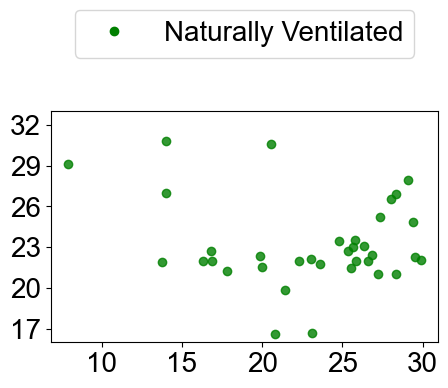

In [101]:
# plot data points
plt.figure(figsize=(5, 3))
sns.regplot(x='t_out_combined', y='temp_n', data=df_bldg_SET_a_ACM, fit_reg=False, scatter_kws={'color': 'green'})
plt.xlabel('', fontsize=20)
plt.ylabel('', fontsize=20)
plt.xticks(np.arange(5, 33, 5), fontsize=20)
plt.yticks(np.arange(17, 33, 3), fontsize=20)
plt.ylim(16, 33)
plt.grid(False)
plt.rcParams['font.family'] ='Arial'
# show legend
plt.plot([], [], 'o', color='green', label='Naturally Ventilated')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2, fontsize=20)
plt.savefig('figs/fig_ACM_SET.pdf', format='pdf', bbox_inches='tight')

# Refutation 3 (YES)

## Alternative regression method

In [102]:
def regression_SET_b(data_bldg):
    """
    set = a * TSV + b
    Regressing Standard Effective Temperature (set) against Thermal Sensation Vote (TSV).
    Use the regression model to derive the neutral temperature by letting TSV equals 0.
    The upper and lower limit of 80% comfort zone are derived by letting TSV equals +-0.85.
    """
    lm_result = smf.ols(formula='set ~ thermal_sensation', data=data_bldg).fit()
    slope = lm_result.params['thermal_sensation']
    intercept = lm_result.params['Intercept']
    # check whether the slope is significant
    if lm_result.pvalues['thermal_sensation'] < 0.05:
        a = slope
        b = intercept
        temp_n = b
        temp_up = 0.85*a + b
        temp_low = (-0.85)*a + b
        sig_model = [slope, intercept, temp_n, temp_up, temp_low]
        return sig_model
    else:
        return [np.nan] * 5

## Alternative SET model result

In [103]:
df_bldg_SET_b = df_bldg.copy()
# Apply the function to each group of df_data_SET grouped by 'building_id'
results = df_data_SET.groupby('building_id').apply(regression_SET_b)
# Convert the grouped results into a DataFrame with appropriate column names
results_df = pd.DataFrame(results.tolist(), index=results.index, columns=['slope', 'intercept', 'temp_n', 'temp_up', 'temp_low'])
# Merge the results back into df_bldg_SET_b
df_bldg_SET_b = df_bldg_SET_b.merge(results_df, left_on='building_id', right_index=True, how='left')

# Get rid of all nan values in the temp_n column
df_bldg_SET_b_sig = df_bldg_SET_b[~df_bldg_SET_b['temp_n'].isna()]
df_bldg_SET_b_ACM = df_bldg_SET_b_sig[(df_bldg_SET_b_sig['cooling_type'] == 'Naturally Ventilated') & (df_bldg_SET_b_sig['building_type'] == 'office')].copy()
print("NV office buildings with significant models:", len(df_bldg_SET_b_ACM))

intercept, slope = weighted_reg(df_bldg_SET_b_ACM['t_out_combined'], df_bldg_SET_b_ACM['temp_n'], df_bldg_SET_b_ACM['records'])

NV office buildings with significant models: 36
p value: 0.000
MSE: 2.6
RMSE: 1.6
                            WLS Regression Results                            
Dep. Variable:                 temp_n   R-squared:                       0.695
Model:                            WLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     77.32
Date:                Mon, 04 Mar 2024   Prob (F-statistic):           2.82e-10
Time:                        13:24:14   Log-Likelihood:                -68.974
No. Observations:                  36   AIC:                             141.9
Df Residuals:                      34   BIC:                             145.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

/var/folders/kr/_5c1r8bn52xbpgz96ksrtrj80000gn/T/ipykernel_47926/425800779.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df_data_SET.groupby('building_id').apply(regression_SET_b)
/var/folders/kr/_5c1r8bn52xbpgz96ksrtrj80000gn/T/ipykernel_47926/2145352812.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('p value: {:.3f}'.format(model.pvalues[1]))


ACM regression line slope: 0.37
ACM regression line intercept: 17.57
ACM 80% comfort zone: 1.75


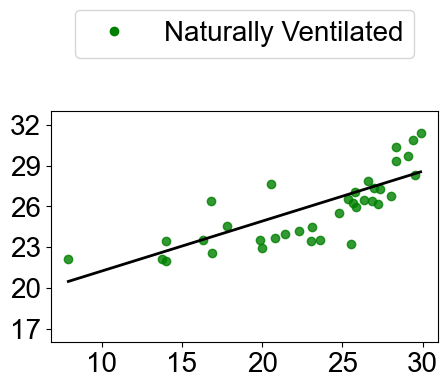

In [106]:
# print the fitted line slope and intercept
print('ACM regression line slope: {:.2f}'.format(slope))
print('ACM regression line intercept: {:.2f}'.format(intercept))
# calculate the mean range of 80% comfort zone
range = df_bldg_SET_b_ACM['temp_up'].mean() - df_bldg_SET_b_ACM['temp_low'].mean()
print('ACM 80% comfort zone: {:.2f}'.format(range))

# sort the data points by t_out_combined
t_out = np.array(df_bldg_SET_b_ACM['t_out_combined'])
t_out = t_out[np.argsort(t_out)]
middle_line = slope * t_out + intercept

# plot data points
plt.figure(figsize=(5, 3))
sns.regplot(x='t_out_combined', y='temp_n', data=df_bldg_SET_b_ACM, fit_reg=False, scatter_kws={'color': 'green'})
plt.plot(t_out, middle_line, color='black', linewidth=2)

plt.xlabel('', fontsize=20)
plt.ylabel('', fontsize=20)
plt.xticks(np.arange(5, 33, 5), fontsize=20)
plt.yticks(np.arange(17, 33, 3), fontsize=20)
plt.ylim(16, 33)
plt.grid(False)
plt.rcParams['font.family'] = 'Arial'
plt.plot([], [], 'o', color='green', label='Naturally Ventilated')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2, fontsize=20)
plt.savefig('figs/fig_ACM_SET_b.pdf', format='pdf', bbox_inches='tight')

## SET model prediction data

Buildings without missing data: 409
Occupants without missing data: 12334
NV-Occupants without missing data: 3141


<Axes: xlabel='thermal_acceptability', ylabel='Count'>

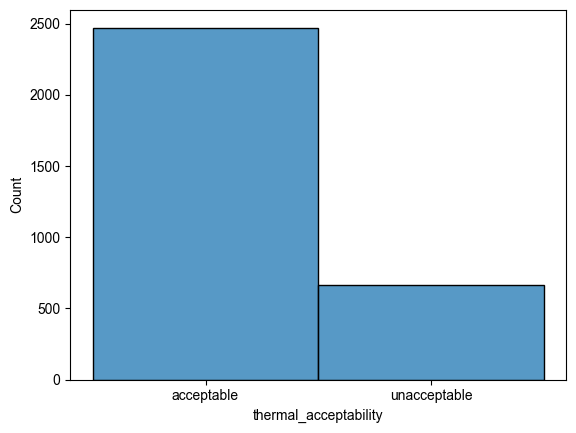

In [111]:
# Select concurrent SET, TSV, and Tout data
df_data_SET_AT = df_rawdata.dropna(subset=['set', 'thermal_acceptability', 't_out_combined'])
print(f'Buildings without missing data:', len(df_data_SET_AT['building_id'].unique()))
print(f'Occupants without missing data:', len(df_data_SET_AT))

# Reset the building cooling type as string, ensuring direct modification of the DataFrame
df_data_SET_AT = df_data_SET_AT.copy()
df_data_SET_AT['cooling_type'] = df_data_SET_AT['cooling_type'].str.title()
df_data_SET_AT_NV = df_data_SET_AT[df_data_SET_AT['cooling_type'] == 'Naturally Ventilated']
print(f'NV-Occupants without missing data:', len(df_data_SET_AT_NV))

sns.histplot(df_data_SET_AT_NV['thermal_acceptability'])

## SET adpative model prediction result

In [135]:
# calculating prediction of thermal acceptance note in NV buildings, all buildings
result = accuracy(0.37, 15.57, 7, df_data_SET_AT_NV, 'set')
print('ASHRAE Adaptive Model Prediction accraucy: {:.0f} %'.format(result*100))
result = accuracy(0, 21.5, 7, df_data_SET_AT_NV, 'set')
print('Fixed Comfort Zone (18-25C) Prediction accraucy: {:.0f} %'.format(result*100))
result = accuracy(0, 26.5, 7, df_data_SET_AT_NV, 'set')
print('Fixed Comfort Zone (23-30C) Prediction accraucy: {:.0f} %'.format(result*100))

ASHRAE Adaptive Model Prediction accraucy: 66 %
Fixed Comfort Zone (18-25C) Prediction accraucy: 38 %
Fixed Comfort Zone (23-30C) Prediction accraucy: 69 %


<Axes: xlabel='t_out_combined', ylabel='set'>

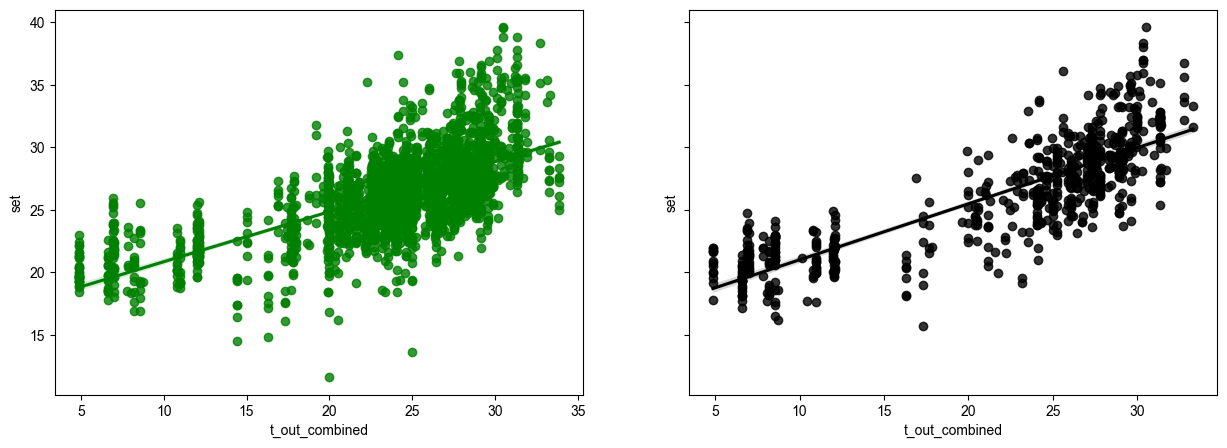

In [176]:
# plot 3 sub plots for different thermal preference, with the same y lim
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
# plot the data points and regression line
sns.regplot(x='t_out_combined', y='set', data=df_data_SET_AT_NV[df_data_SET_AT_NV['thermal_acceptability'] == 'acceptable'], color='green', ax=ax[0])
sns.regplot(x='t_out_combined', y='set', data=df_data_SET_AT_NV[df_data_SET_AT_NV['thermal_acceptability'] == 'unacceptable'], color='black', ax=ax[1])

# Refutation 4

## Data

<Axes: xlabel='t_out_combined', ylabel='set'>

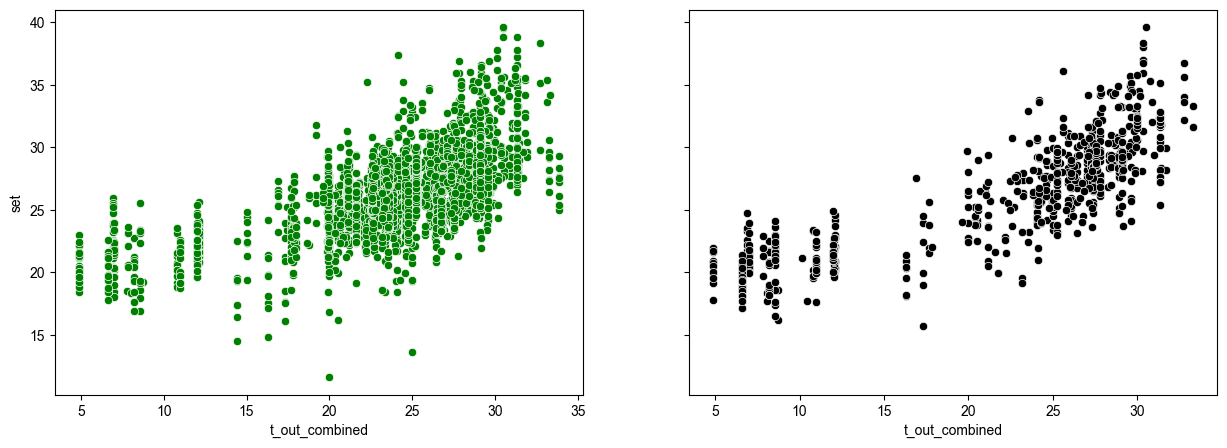

In [172]:
# Select concurrent Top, Thermal acceptance vote, and Tout data
df_data_TP = df_rawdata.dropna(subset=['set', 'thermal_preference','t_out_combined'])
print(f'Buildings without missing data:', len(df_data_TP ['building_id'].unique()))
print(f'Occupants without missing data:', len(df_data_TP))

# Reset the building cooling type as string, ensuring direct modification of the DataFrame
df_data_TP = df_data_TP.copy()
df_data_TP['cooling_type'] = df_data_TP['cooling_type'].str.title()
# check the distribution of thermal acceptability in df_data_TP_NV
sns.histplot(df_data_TP['thermal_preference'])

<Axes: xlabel='t_out_combined', ylabel='set'>

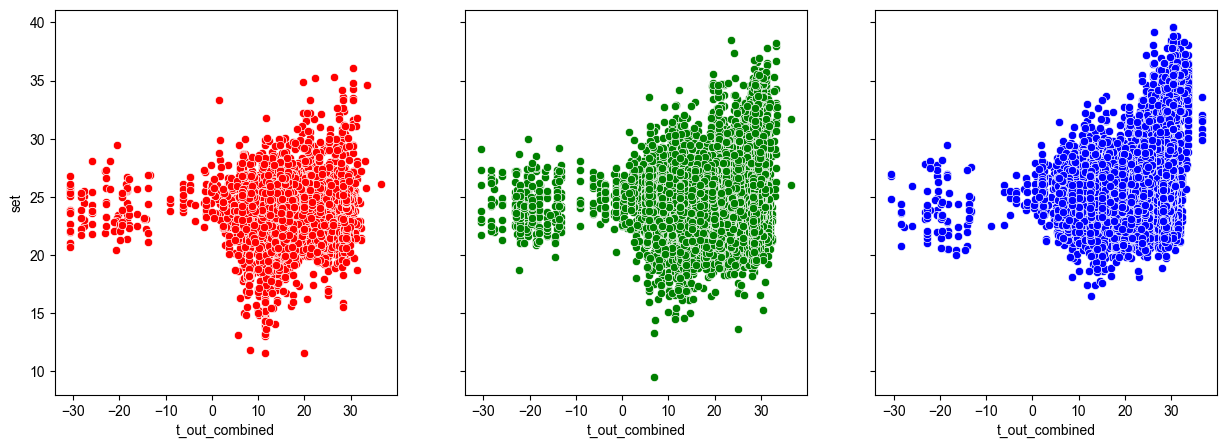

In [166]:
# plot 3 sub plots for different thermal preference, with the same y lim
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
# plot the data points
sns.scatterplot(x='t_out_combined', y='set', data=df_data_TP[df_data_TP['thermal_preference'] == 'warmer'], color='red', ax=ax[0])
sns.scatterplot(x='t_out_combined', y='set', data=df_data_TP[df_data_TP['thermal_preference'] == 'no change'], color='green', ax=ax[1])
sns.scatterplot(x='t_out_combined', y='set', data=df_data_TP[df_data_TP['thermal_preference'] == 'cooler'], color='blue', ax=ax[2])

## TP prediction accuracy method

In [168]:
def accuracy_TP(slope, intercept, zone, df, temp):
    """
    Calculate the accuracy of a ACM model based on the df, using a calssification method.
    If the temp is in the comfort zone and the vote is acceptable, then it is classified as 1, or
    If the temp is out of the comfort zone and the vote is unacceptable, then it is classified as 1, otherwies 0.
    Count the percentage of 1 over total records in df as the prediction accuracy.
    """
    df.count = np.where(
        # Case 1: Comfortable when within zone
        ((df.thermal_acceptability == 'no change') & 
         (df[temp] >= df.t_out_combined * slope + intercept - zone/2) & 
         (df[temp] <= df.t_out_combined * slope + intercept + zone/2)) |
        # Case 2: Uncomfortable when out of zone
        (((df.thermal_acceptability == 'warmer') |
          (df.thermal_acceptability == 'cooler')) & 
         ((df[temp] < df.t_out_combined * slope + intercept - zone/2) | 
          (df[temp] > df.t_out_combined * slope + intercept + zone/2)),
        1,  # Accurate prediction
        0))   # Inaccurate prediction
    percent = len(df[df.count == 1])/len(df)
    return percent

## Result

In [169]:
# calculating prediction of thermal acceptance note in NV buildings, all buildings
result = accuracy(0.37, 15.57, 7, df_data_TP, 'set')
print('ASHRAE Adaptive Model Prediction accraucy: {:.0f} %'.format(result*100))
result = accuracy(0, 21.5, 7, df_data_TP, 'set')
print('Fixed Comfort Zone (18-25C) Prediction accraucy: {:.0f} %'.format(result*100))
result = accuracy(0, 26.5, 7, df_data_TP, 'set')
print('Fixed Comfort Zone (23-30C) Prediction accraucy: {:.0f} %'.format(result*100))

ASHRAE Adaptive Model Prediction accraucy: 26 %
Fixed Comfort Zone (18-25C) Prediction accraucy: 22 %
Fixed Comfort Zone (23-30C) Prediction accraucy: 24 %


<Axes: xlabel='t_out_combined', ylabel='set'>

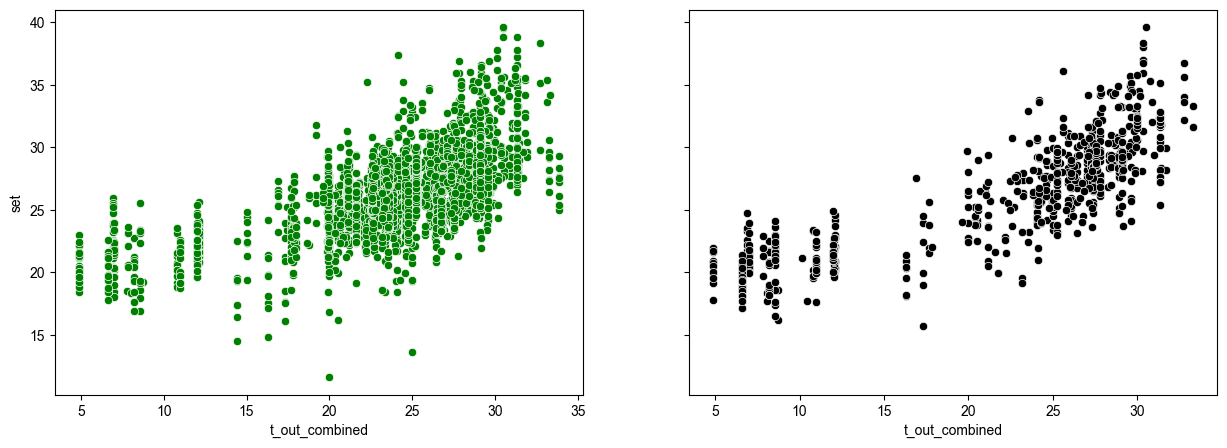